# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess, workers = 30)

Loading ychr


In [3]:
gt <- read_vcf(here("data/vcf/full_modern.vcf.gz"), mindp = 3, maxdp = 0.98) %>% select(-ustishim)

In [5]:
samples <- read_info(gt)

In [7]:
branch_lengths <- 
    crossing(
        a = filter(samples, pop == "Africa")$name,
        b = filter(samples, pop != "Africa", pop != "EMH")$name
    ) %>%
    pmap_dfr(function(a, b) {
        x <- gt[, c("chimp", a, b)] %>% filter(complete.cases(.))

        tibble(
            afr = a,
            nonafr = b,
            nonafr_der = sum(x[["chimp"]] == x[[a]] & x[["chimp"]] != x[[b]]),
            afr_der = sum(x[["chimp"]] == x[[b]] & x[["chimp"]] != x[[a]]),
            ratio = afr_der / nonafr_der,
            total = nrow(x)
        )    
    })

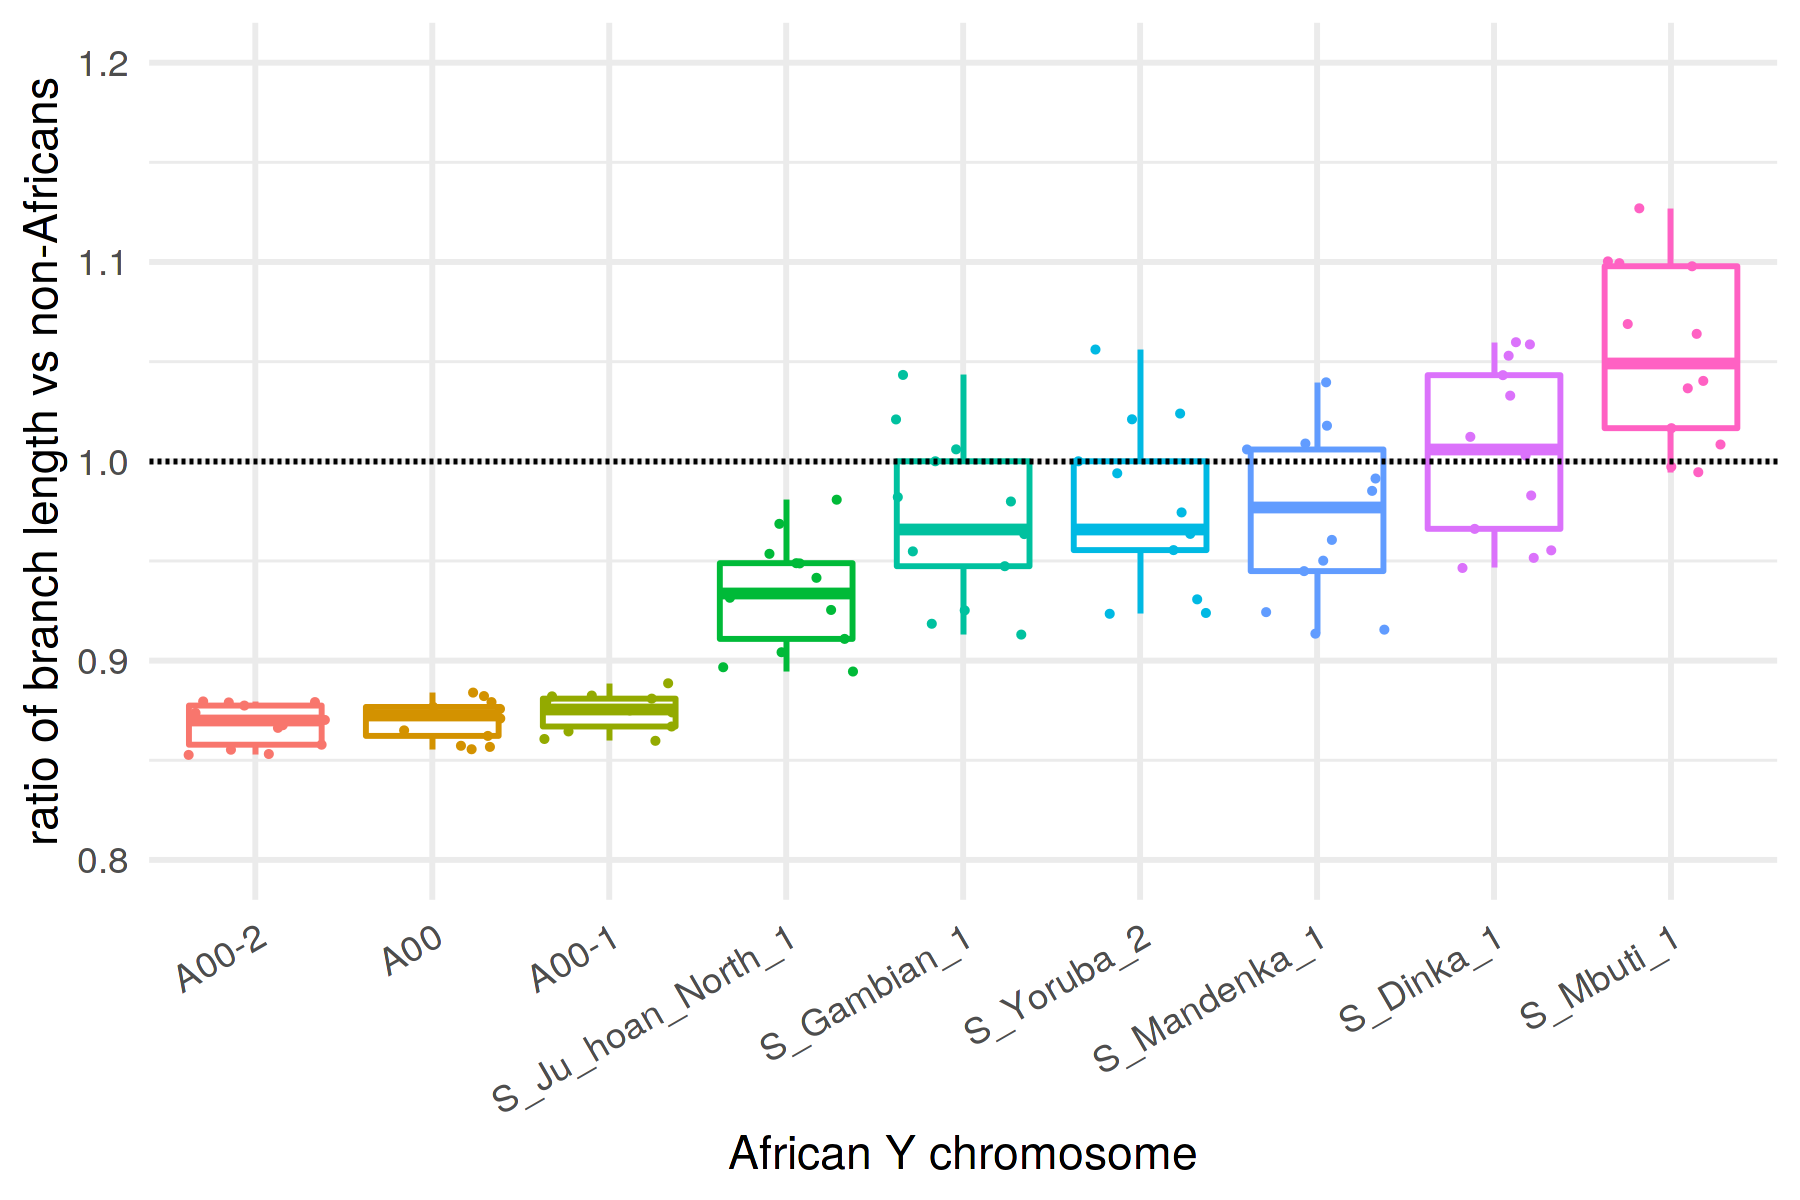

In [188]:
set_dim(6, 4)

branch_lengths %>%
mutate(afr = fix_name(afr)) %>%
ggplot(aes(fct_reorder(afr, ratio), ratio, color = fct_reorder(afr, ratio))) +
    geom_boxplot() +
    geom_jitter(size = 0.25) +
    geom_hline(yintercept = 1, linetype = 2) +
    labs(x = "African Y chromosome", y = "ratio of branch length vs non-Africans") +
    theme_minimal() +
    theme(
        legend.position = "none",
        axis.text.x = element_text(hjust = 1, angle = 30)
    ) +
    coord_cartesian(y = c(0.8, 1.2))

# $\textrm{TMRCA}_{\textrm{archaic}}$ estimates using different African populations

In [33]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

The choice of an African does not matter as long as the coverage in an archaic individual isn't too low. For very low coverage samples, estimates are stable only when the A00 lineage is used (to see this, compare with the high coverage Mez2).

In [301]:
tmrca_long <- tmrca_df %>%
    filter(
        !str_detect(afr, "Mbuti|Dinka"),
        (capture == "full" & !str_detect(arch, "shotgun|snpad")) | (capture == "lippold" & arch == "elsidron2"),
        sites == "all",
        filt == "filt50",
        dp == 3
    ) %>%
    select(arch, afr, tmrca_new, tmrca_mendez) %>%
    gather(statistic, value, -arch, -afr) %>%
    mutate(name = fix_name(arch), afr = fix_name(afr)) %>%
    mutate(statistic = ifelse(statistic == "tmrca_mendez",
                          "TMRCA statistic of Mendez et al.",
                          "New TMRCA statistic"),
       name = str_replace(arch, "mez2_dp(\\d+)", "subsampled to \\1X") %>% fix_name) %>%
    mutate(name = ifelse(str_detect(name, "560"), "El Sidrón 1253\n(560 kb)", name))

## new TMRCA

In [302]:
set_dim(7, 3.5)

p_new_mez2subs <- filter(tmrca_long, str_detect(arch, "mez2"), statistic == "New TMRCA statistic") %>%
mutate(name = fct_relevel(name, "Mezmaiskaya 2", paste0("subsampled to ", 1:10, "X"))) %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2) +
    geom_vline(xintercept = 1.5, size = 0.25, linetype = 5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 500e3)) +
    guides(fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

In [348]:
set_dim(7, 3.5)

p_new_arch <- filter(tmrca_long, !str_detect(arch, "mez2_dp|shotgun|snpad|den$"), statistic == "New TMRCA statistic") %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2, alpha = 0.5) +
    geom_point(aes(color = fct_reorder(afr, -value)),
               position = position_dodge(width = 0.75), size = 0.5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 1e6)) +
    guides(color = F, fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

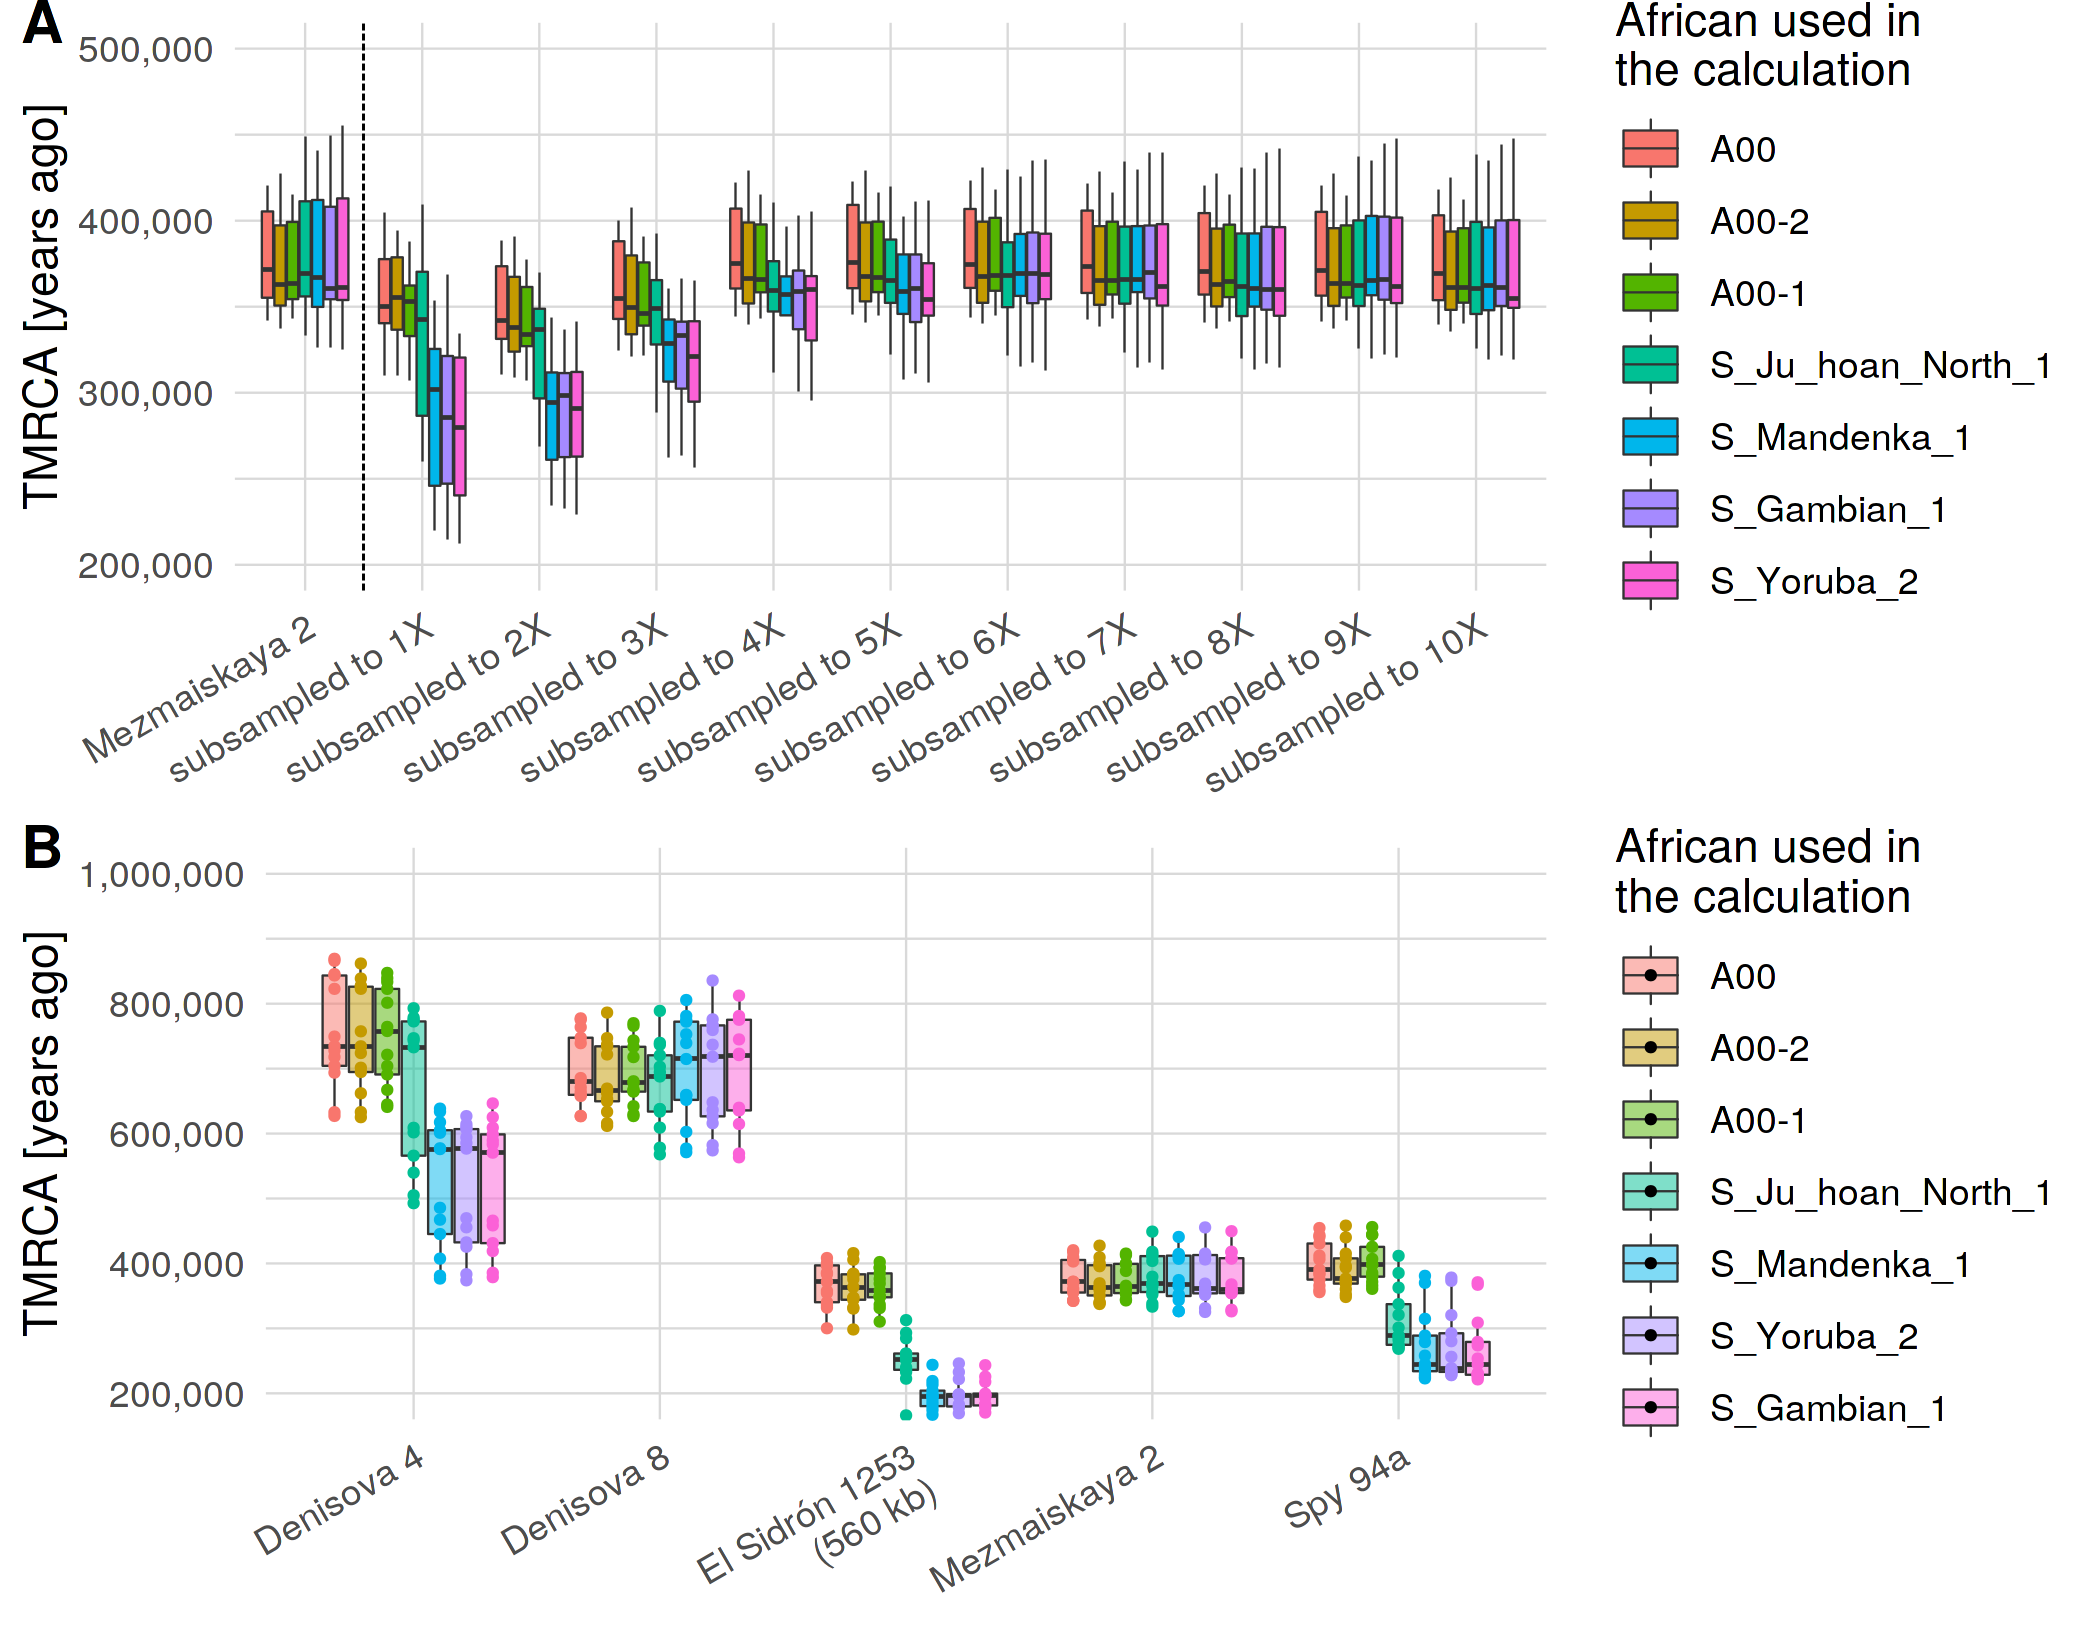

In [349]:
set_dim(7, 5.5)

plot_grid(p_new_mez2subs, p_new_arch, nrow = 2, labels = c("A", "B"), vjust = 1)

## Mendez et al. TMRCA

In [351]:
set_dim(7, 3.5)

p_mendez_mez2subs <- filter(tmrca_long, str_detect(arch, "mez2"), statistic == "TMRCA statistic of Mendez et al.") %>%
mutate(name = fct_relevel(name, "Mezmaiskaya 2", paste0("subsampled to ", 1:10, "X"))) %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2) +
    geom_vline(xintercept = 1.5, size = 0.25, linetype = 5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 500e3)) +
    guides(fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

In [352]:
set_dim(7, 3.5)

p_mendez_arch <- filter(tmrca_long, !str_detect(arch, "mez2_dp|shotgun|snpad|den$"), statistic == "TMRCA statistic of Mendez et al.") %>%
ggplot(aes(name, value, fill = fct_reorder(afr, -value))) +
    geom_boxplot(outlier.shape = NA, size = 0.2, alpha = 0.5) +
    geom_point(aes(color = fct_reorder(afr, -value)),
               position = position_dodge(width = 0.75), size = 0.5) +
    theme_minimal() +
    theme(
        legend.position = "right",
        axis.text.x = element_text(hjust = 1, angle = 30),
        axis.title.x = element_blank()
    ) +
    labs(y = "TMRCA [years ago]") +
#    facet_wrap(statistic ~ ., nrow = 1) +
    coord_cartesian(ylim = c(200e3, 1e6)) +
    guides(color = F, fill = guide_legend(title = "African used in\nthe calculation")) +
    scale_y_continuous(labels = scales::comma) +
    background_grid(major = "xy", minor = "xy", size.major = 0.2, size.minor = 0.2)

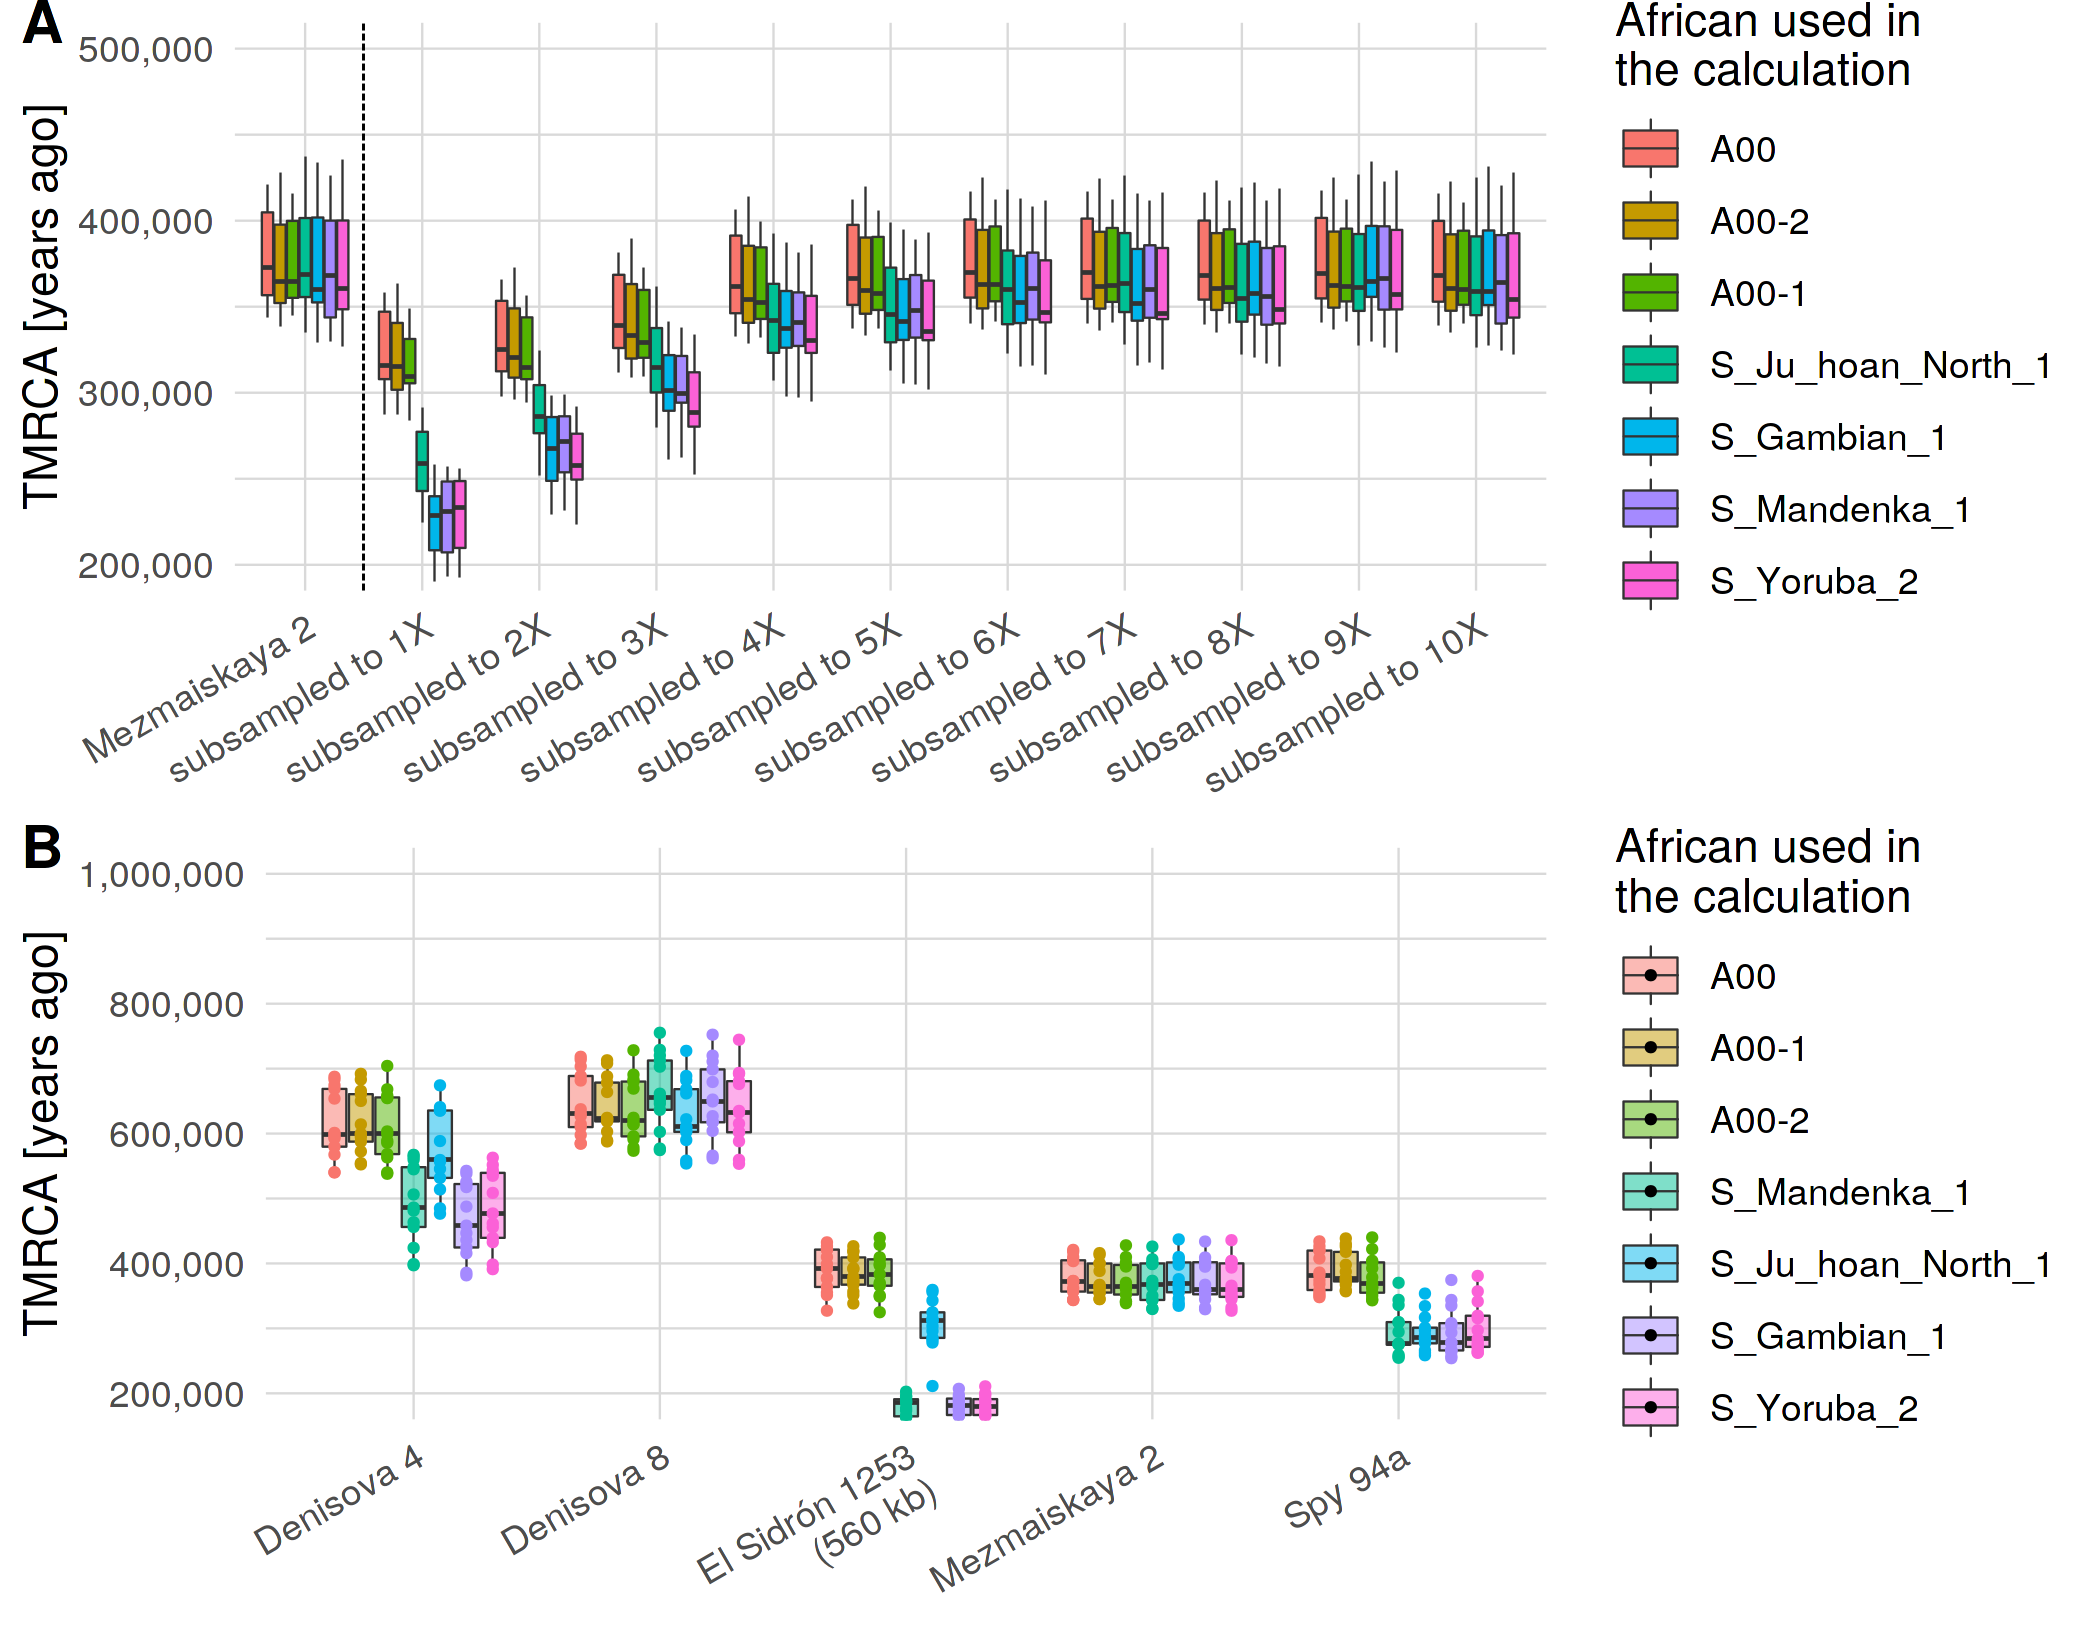

In [353]:
set_dim(7, 5.5)

plot_grid(p_mendez_mez2subs, p_mendez_arch, nrow = 2, labels = c("A", "B"), vjust = 1)

In [360]:
tmrca_df %>%
filter(
    !str_detect(arch, "mez2_dp|shotgun|snpad|den$"),
    !str_detect(afr, "Mbuti|Dinka"),
    capture == "full" | (capture == "lippold" & arch == "elsidron2"),
    sites == "nodmg",
    filt == "filt50") %>%
filter(dp == 3) %>% filter(arch %in% c("den4", "den8")) %>%
group_by(arch, afr) %>%
mutate(alpha = (a + d) / d) %>%
summarise_if(is.numeric, mean) %>% arrange(tmrca_new) %>%
mutate(x = tmrca_afr * alpha) %>% arrange(afr) %>% mutate(a/d) %>%
select(-mut_rate, -tmrca_afr, -tmrca_mendez, -dp)

arch,afr,a,b,c,d,e,f,total,tmrca_new,alpha,x,a/d
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
den8,a00,583.4615,8.846154,8.5384615,318.00000,410.38462,583.9231,3372263,706874.9,2.836391,706861.6,1.834785
den4,a00,142.1538,2.000000,2.1538462,77.76923,125.84615,165.9231,1084364,708133.1,2.836737,706947.8,1.827893
den4,a00_1,139.1538,2.000000,1.1538462,78.38462,116.84615,162.8462,1050941,687340.6,2.781816,686430.8,1.775270
den8,a00_1,569.5385,5.846154,8.6153846,313.00000,395.38462,571.3077,3273277,696236.6,2.821219,696153.8,1.819612
den4,a00_2,138.4615,2.000000,1.1538462,78.38462,121.84615,165.9231,1083194,685986.7,2.772805,685089.5,1.766438
den8,a00_2,574.9231,8.846154,8.6153846,320.53846,408.38462,583.8462,3371033,690561.7,2.795278,690642.1,1.793617
den4,S_Gambian_1,193.4615,1.000000,0.6153846,29.53846,34.23077,171.7692,1091757,551675.5,7.715553,548787.2,6.549479
den8,S_Gambian_1,822.3077,8.000000,1.8461538,92.84615,112.92308,592.6154,3390985,709743.0,9.974946,709492.0,8.856669
den8,S_Ju_hoan_North_1,769.5385,3.000000,2.7692308,138.76923,148.23077,595.1538,3391239,647012.0,6.572876,647057.7,5.545455


In [248]:
x <- tmrca_df %>%
filter(afr == "a00", capture == "full" & arch %in% c("mez2"),
       sites == "all", filt == "filt50", dp == 3) %>%
select(arch, tmrca_afr, a:f) %>%
group_by(arch) %>%
summarise_if(is.numeric, mean) %>%
mutate_if(is.numeric, as.integer)

In [250]:
map_dfr(1:10, ~ mutate(x, arch = paste0(arch, "_", .), e = e * (1 + 1/(10 - (. - 1))))) %>%
add_tarch_new %>%
add_tarch_mendez

arch,tmrca_afr,a,b,c,d,e,f,tmrca_new,tmrca_mendez
<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
mez2_1,249211,483,46,25,936,1015.300,1132,377810.3,372584.0
mez2_2,249211,483,46,25,936,1025.556,1132,377810.3,371939.0
mez2_3,249211,483,46,25,936,1038.375,1132,377810.3,371142.2
mez2_4,249211,483,46,25,936,1054.857,1132,377810.3,370132.7
mez2_5,249211,483,46,25,936,1076.833,1132,377810.3,368812.5
mez2_6,249211,483,46,25,936,1107.600,1132,377810.3,367011.9
mez2_7,249211,483,46,25,936,1153.750,1132,377810.3,364410.3
mez2_8,249211,483,46,25,936,1230.667,1132,377810.3,360320.8
mez2_9,249211,483,46,25,936,1384.500,1132,377810.3,352954.9
